# Ford GoBike (Bay Wheel Bike) Usage trend analysis
## by Yunhan Zhu

## Investigation Overview

Usage has been improving over time. 

Most Bay Wheel bike trips were made by subscribers, most of which fall between 25-35 years old. 

Most rides are between 0.5-2km, within 15 minutes.

Duration tends to increase with distance, but longer duration doesn't always gurantee longer distance.

Weekdays and weekends also have different usage patterns.  There exists a similar discrepancy 1/ when users choose bike share for only part of the trip and whole trip, and 2/age group (20-30 vs 25-35), to that of the different usage patterns on weekdays and weekends. Suggesting that there might be more working age adults using bike sharing for part of the trip, possibly for commuting purposes, during weekdays.

## Dataset Overview

We used the anonymous usage data of Ford GoBike/Bay Wheel Bike for this analysis. The original data was downloaded from Ford GoBike/Bay Wheel Bike website, giving us over 4 million bike share entries between June 2017 and October 2019. Each entry has 16 features, including bike id, bike_share_for_all_trip, duration by second, start & end station details (id, longitude, latitude, station name), start & end time, member details (birth year, gender), and user type. Some features are numerical (such as duration), but most others are categorical.

For the purpose of our study, we have removed the entries with missing details. It is also worth noting that because data entries prior to 2018 are missing bike_share_for_all_trip details, they have been eliminated from our analysis. Overall, these changes narrow down our scope to 3.5 million entries.

In addition, we have also added some new features based on the existing information, including 1/ weekday, weekday type, year month based on start time; 2/distance based on star & end station longitude and latitude; 3/member age based on start time and member birth year.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import glob

%matplotlib inline

from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile
import datetime
import math
import calendar

In [2]:
# load in the dataset into a pandas dataframe
subset = pd.read_csv('clean.csv')
subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479859 entries, 0 to 3479858
Data columns (total 12 columns):
Unnamed: 0                 int64
bike_share_for_all_trip    object
member_gender              object
user_type                  object
member_age                 float64
duration_min               float64
distance_km                float64
start_hour                 int64
weekday                    object
start_time                 object
year_month                 object
weekday_type               object
dtypes: float64(3), int64(2), object(7)
memory usage: 318.6+ MB


In [3]:
# change the columns to the right type
subset.bike_share_for_all_trip = subset.bike_share_for_all_trip.astype('category')
subset.member_gender = subset.member_gender.astype('category')
subset.user_type = subset.user_type.astype('category')
subset.start_hour = subset.start_hour.astype('category')
subset.weekday = subset.weekday.astype('category')
subset.weekday_type = subset.weekday_type.astype('category')

subset.start_time = pd.to_datetime(subset.start_time)

#drop the unnamed column
subset.drop('Unnamed: 0',axis=1,inplace=True)

#check if the change has been made 
subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479859 entries, 0 to 3479858
Data columns (total 11 columns):
bike_share_for_all_trip    category
member_gender              category
user_type                  category
member_age                 float64
duration_min               float64
distance_km                float64
start_hour                 category
weekday                    category
start_time                 datetime64[ns]
year_month                 object
weekday_type               category
dtypes: category(6), datetime64[ns](1), float64(3), object(1)
memory usage: 152.7+ MB


## Usage has improved over time

Usage has improved steadily since the launch of the service. Whilst usage dropped briefly during the three months between May and July 2019, that has recovered since Aug 2019.

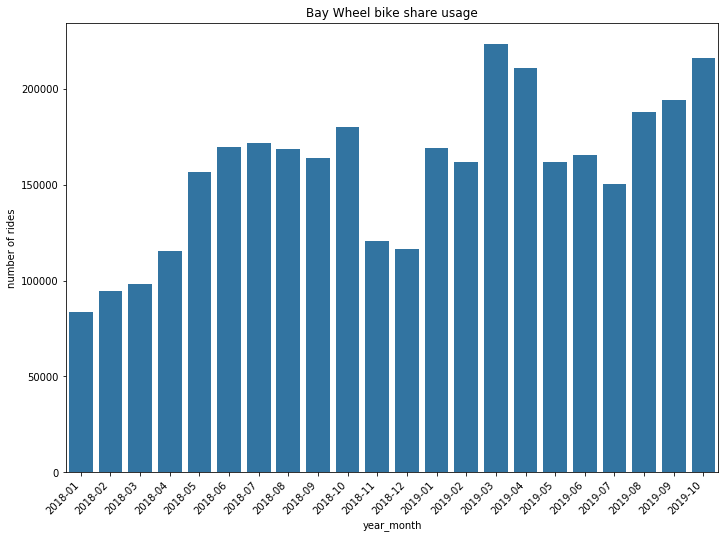

In [4]:
base_color = sb.color_palette()[0]

plt.figure(figsize=(11.69,8.27))
p = sb.countplot(data=subset.sort_values(by=['year_month']), x='year_month',color=base_color);
p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.xlabel('year_month');
plt.ylabel('number of rides');
plt.title('Bay Wheel bike share usage');

## User type & age distribution 

Most Bay Wheel bike trips were made by subscribers, 

Most subscribers fall between 25-35 years old 


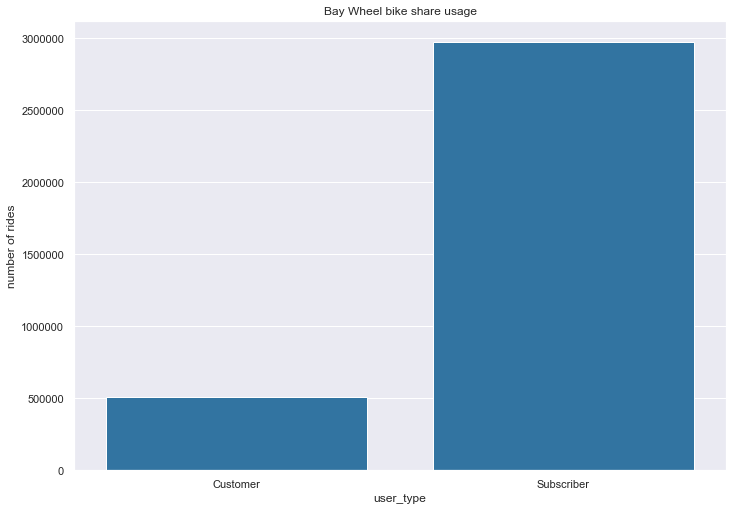

In [5]:
# see user type distribution 
sb.set(rc={'figure.figsize':(11.7,8.27)})
sb.countplot(data = subset, x = 'user_type', color = base_color)
plt.ylabel('number of rides');
plt.title('Bay Wheel bike share usage');

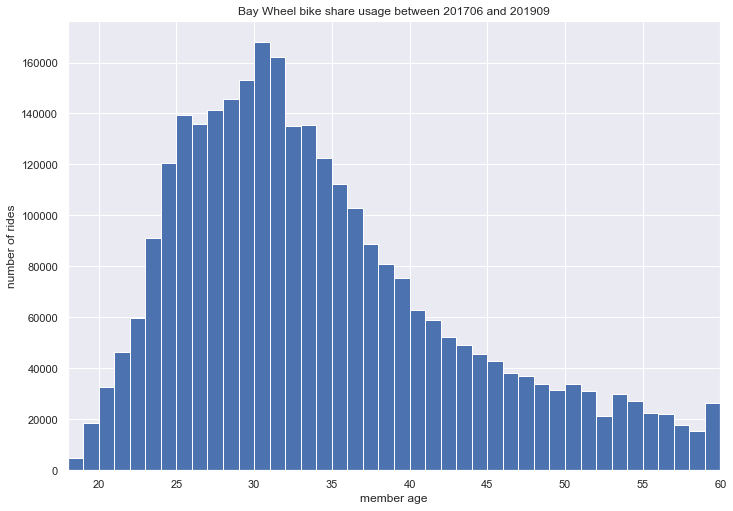

In [6]:
bin_edges = np.arange(18, 61, 1)
plt.hist(data = subset, x = 'member_age', bins = bin_edges);
plt.xlabel('member age')
plt.ylabel('number of rides');
plt.title('Bay Wheel bike share usage between 201706 and 201909');
plt.xlim(18,60);

## Distance & Duration distribution 
Most rides are between 0.5-2km

Duration are mostly within 15 minutes

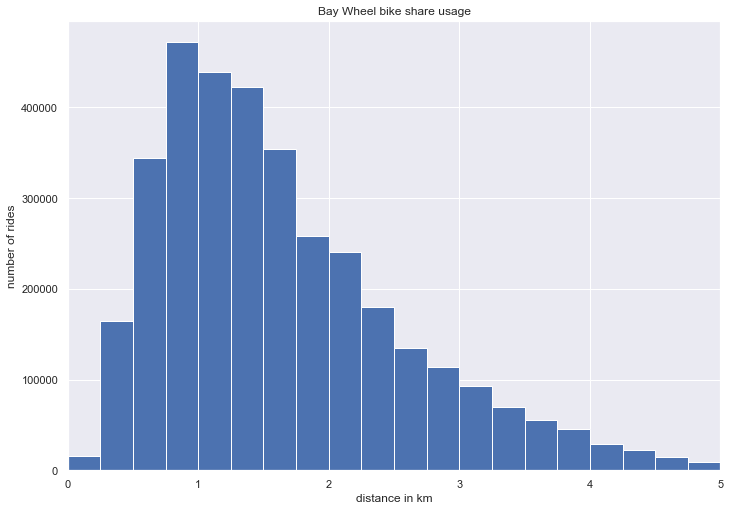

In [7]:
# draw a histogram on distance
bin_edges = np.arange(0, 5+0.25, 0.25)
plt.hist(data = subset, x = 'distance_km', bins = bin_edges);
plt.xlabel('distance in km')
plt.ylabel('number of rides');
plt.title('Bay Wheel bike share usage');
plt.xlim(0,5);

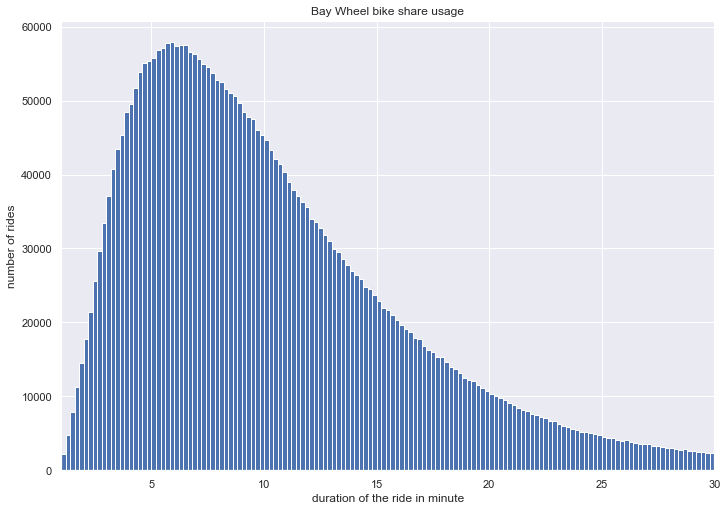

In [8]:
bin_edges = np.arange(1, 30.2, 0.2)
plt.hist(data = subset, x = 'duration_min', bins = bin_edges);
plt.xlabel('duration of the ride in minute');
plt.ylabel('number of rides');
plt.title('Bay Wheel bike share usage');
plt.xlim(1,30);

## Distance vs duration 

Duration tends to increase with distance, but longer duration doesn't always guarantee longer distance.


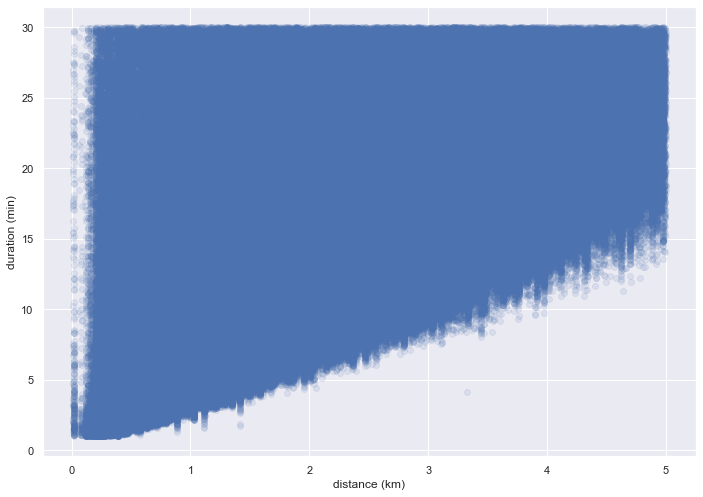

In [9]:
plt.scatter(data = subset, x = 'distance_km', y = 'duration_min', alpha = 1/10)
plt.xlabel('distance (km)')
plt.ylabel('duration (min)')
plt.show()

## Weekday vs Weekends

On weekdays, there are two peak periods between 7-10am and 4-7pm, with a greater number of rides and a larger number of longer rides by both duration and distance.

On weekend, rides are normally distributed throughout the day between 7-10am, and longer rides (by both distance and duration) also happen during the peak period between 1-4pm.

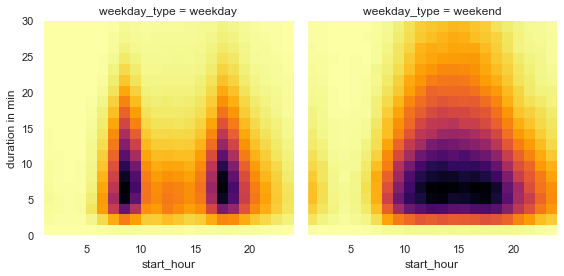

In [10]:
def hist2dgrid(x, y, **kwargs):
    palette = kwargs.pop('color')
    bins_x = np.arange(1, 25, 1)
    bins_y = np.arange(0, y.max()+y.max()/20, y.max()/20)
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 0.5)

# create faceted heat maps on start hour, duration, and type of weekday 
g = sb.FacetGrid(data = subset, col = 'weekday_type', col_wrap=2, height = 4)
g.map(hist2dgrid, 'start_hour', 'duration_min', color = 'inferno_r')
g.set_xlabels('start_hour')
g.set_ylabels('duration in min')

plt.show()

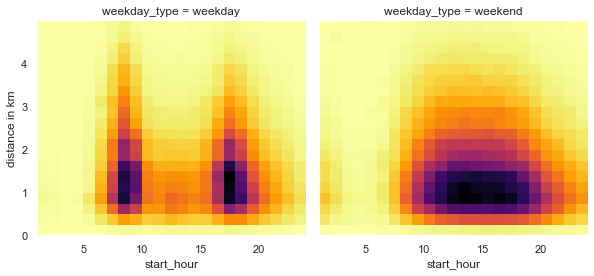

In [11]:
# chang weekday to weekday_type
g = sb.FacetGrid(data = subset, col = 'weekday_type', col_wrap = 7, height = 4)
g.map(hist2dgrid, 'start_hour', 'distance_km', color = 'inferno_r')
g.set_xlabels('start_hour')
g.set_ylabels('distance in km')

plt.show()

## Bike share for whole trip vs part of the trip 

When users use bike share for only part of the trip, the behavior is similar to that on weekdays, i.e. there are two peak periods between 7-10am and 4-6pm, with more longer rides happening in those two periods. This suggests people tend to use more bike share as part of the trip during the weekdays.

When users use bike share for the entire ride, the behavior is similar to that on weekends, although there is one less obvious peak period between 4-6pm. This implies that people are more likely choosing bike share for the entire ride, possibly for leisure purposes during the afternoon, over the weekend. On the other hand, duration is more centred between 3-10 minutes, suggesting people are less likely to use bike share for longer rides over the weekend. This is also in line with our earlier conclusion, that people might prefer to use bike share for leisure rides over the weekend.




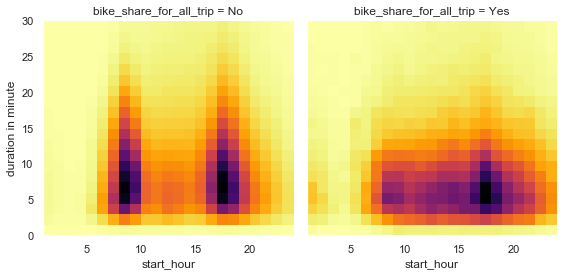

In [12]:
# create faceted heat maps on start hour, distance, and days of the week 
g = sb.FacetGrid(data = subset, col = 'bike_share_for_all_trip', col_wrap = 2, height = 4)
g.map(hist2dgrid, 'start_hour', 'duration_min', color = 'inferno_r')
g.set_xlabels('start_hour')
g.set_ylabels('duration in minute')

plt.show()

## Usage pattern by age group

weekdays peak hour rides are taken by older adults (aged between 25-35)

weekends see more rides by younger adults (aged between 20-30)

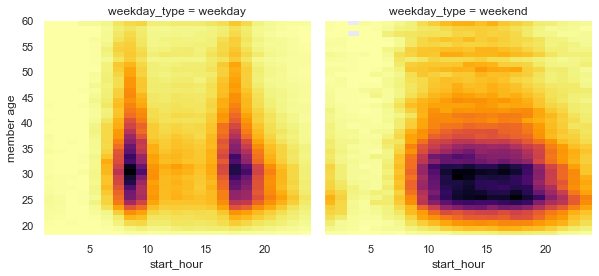

In [13]:
def hist2dgrid_age(x, y, **kwargs):
    palette = kwargs.pop('color')
    bins_x = np.arange(1, 25, 1)
    bins_y = np.arange(18, 61, 1)
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 0.5)

g = sb.FacetGrid(data = subset, col = 'weekday_type', col_wrap=7, height = 4)
g.map(hist2dgrid_age, 'start_hour', 'member_age', color = 'inferno_r')
g.set_xlabels('start_hour')
g.set_ylabels('member age')

plt.show()

## Conclusion

Ford GoBike (Bay Wheel Bike) is seeing improving usage contributed by an increasing number of subscribers, most of which fall between 25-35 years old. 

Most rides are between 0.5-2km, within 15 minutes.Duration tends to increase with distance, but longer duration doesn't always gurantee longer distance.

Weekdays and weekends also have different usage patterns.  There exists a similar discrepancy 1/ when users choose bike share for only part of the trip and whole trip, and 2/age group (20-30 vs 25-35), to that of the different usage patterns on weekdays and weekends. Suggesting that there might be more working age adults using bike sharing for part of the trip, possibly for commuting purposes, during weekdays.

In [14]:
!jupyter nbconvert "slide_deck.ipynb" --to slides --post serve --template output_toggle

[NbConvertApp] Converting notebook slide_deck.ipynb to slides
[NbConvertApp] Writing 586190 bytes to slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\yunhan\AppData\Local\Continuum\anaconda3\Scripts\jupyter-nbconvert-script.py", line 9, in <module>
    sys.exit(main())
  File "C:\Users\yunhan\AppData\Local\Continuum\anaconda3\lib\site-packages\jupyter_core\application.py", line 267, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\yunhan\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\yunhan\AppData\Local\Continuum\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 338, in start
    self.convert_notebooks()
  File "C:\Users\yunhan\AppData\Local\Continuum\anaconda3\lib\site-packages\nbconvert\n